# Classification of SDSS data by a neural network from scratch

- [ゼロから作る Deep Learning](https://www.amazon.co.jp/dp/4873117585/ref=cm_sw_em_r_mt_dp_U_EIM4CbNAFTP6A) を参考に、ニューラルネットワークを Python で実装し、SDSS カタログデータの分類を試みる

In [1]:
# from standard library
from copy import deepcopy

# from dependent packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from astroML.datasets import fetch_sdss_galaxy_colors
from common.functions import sigmoid, softmax
from common.functions import sigmoid_grad, cross_entropy_error

## Load dataset

- これまでと同様に SDSS カタログデータから galaxies と QSOs のデータを取得する
- なお、astroML v0.4 では、以前問題となっていたデータ取得関数のバグが修正されているようだ

In [2]:
data_dir = Path().resolve().parent/'dataset'
df = pd.DataFrame(fetch_sdss_galaxy_colors(data_dir))
df['u-g'] = df['u'] - df['g']
df['g-r'] = df['g'] - df['r']

N = 8000
gal = df[df['specClass']=='GALAXY'].sample(N)
qso = df[df['specClass']=='QSO'].sample(N)

(-0.5, 1.5)

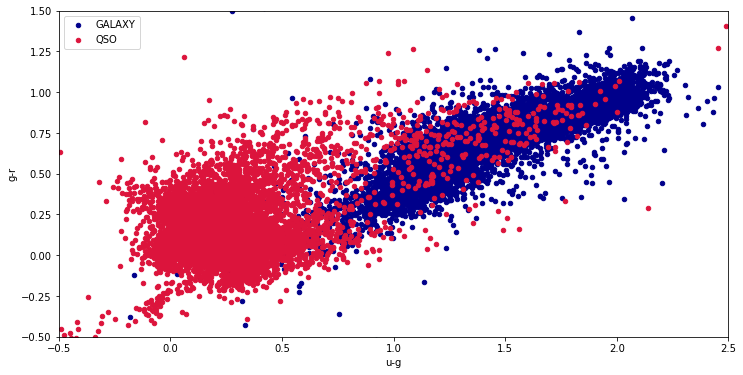

In [3]:
fig, ax = plt.subplots(figsize=(12, 6))
gal.plot.scatter(x='u-g', y='g-r', ax=ax, c='darkblue', label='GALAXY')
qso.plot.scatter(x='u-g', y='g-r', ax=ax, c='crimson', label='QSO')
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-0.5, 1.5)

- トレーニングデータとテストデータに分ける
- 今回使用するネットワークは、クラスが one-hot 表現 (one-versus-one-classifier) として分類されている

In [4]:
N_train = int(N*0.8)
df_train = pd.concat([gal[:N_train], qso[:N_train]])
df_test  = pd.concat([gal[N_train:], qso[N_train:]])

In [5]:
x_train = df_train[['u-g', 'g-r']].to_numpy()
x_test  = df_test[['u-g', 'g-r']].to_numpy()

t_train = pd.concat([df_train['specClass']=='QSO',
                     df_train['specClass']!='QSO'], axis=1).to_numpy(int)
t_test  = pd.concat([df_test['specClass']=='QSO',
                     df_test['specClass']!='QSO'], axis=1).to_numpy(int)

## Two-layer network

- [ゼロから作る Deep Learning](https://www.amazon.co.jp/dp/4873117585/ref=cm_sw_em_r_mt_dp_U_EIM4CbNAFTP6A) p.114 の2層ニューラルネットワークを使用する

In [6]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        return y
    
    def loss(self, x, t):
        y = self.predict(x)
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        return np.sum(y==t) / float(x.shape[0])
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        grads = {}        
        dy = (y-t) / x.shape[0]
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        dz1 = np.dot(dy, W2.T)
        da1 = sigmoid_grad(a1) * dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)
        
        return grads

### 隠れユニット数が3の場合

In [7]:
np.random.seed(2019)
network = TwoLayerNet(2, 3, 2)

N_iter = 2000
N_epoch = 20

epochs = np.arange(1, N_epoch+1)
train_losses = []
train_accs = []
test_accs = []

for i in tqdm(range(N_iter)):
    grad = network.gradient(x_train, t_train)
    
    for key in network.params:
        network.params[key] -= 0.1 * grad[key]
    
    if not i%int(N_iter/N_epoch):
        train_losses.append(network.loss(x_train, t_train))    
        train_accs.append(network.accuracy(x_train, t_train))
        test_accs.append(network.accuracy(x_test, t_test))

100%|██████████| 2000/2000 [00:04<00:00, 418.73it/s]


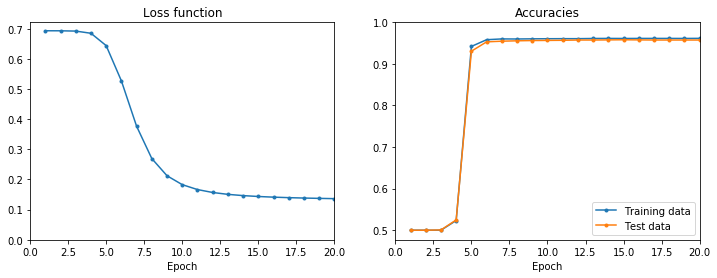

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
ax.plot(epochs, train_losses, '.-')
ax.set_title('Loss function')
ax.set_xlabel('Epoch')
ax.set_xlim(0, N_epoch)
ax.set_ylim(0, None)

ax = axes[1]
ax.plot(epochs, train_accs, '.-', label='Training data')
ax.plot(epochs, test_accs, '.-', label='Test data')
ax.set_title('Accuracies')
ax.set_xlabel('Epoch')
ax.set_xlim(0, N_epoch)
ax.set_ylim(None, 1)
ax.legend()

(-0.5, 1.5)

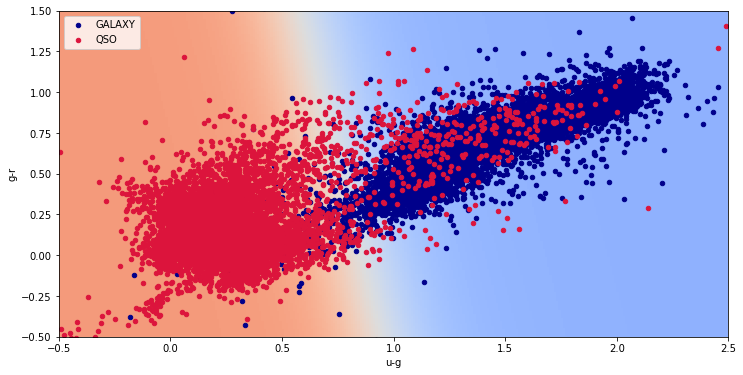

In [9]:
x0, x1 = np.meshgrid(np.arange(-1, 3, 0.01), np.arange(-1, 3, 0.01))
x = np.vstack([x0.flatten(), x1.flatten()]).T
t0 = network.predict(x).T[0].reshape(x0.shape)

fig, ax = plt.subplots(figsize=(12, 6))

ax.pcolormesh(x0, x1, t0, cmap='coolwarm', vmin=-0.5, vmax=1.5)
gal.plot.scatter(x='u-g', y='g-r', ax=ax, c='darkblue', label='GALAXY')
qso.plot.scatter(x='u-g', y='g-r', ax=ax, c='crimson', label='QSO')
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-0.5, 1.5)

### 隠れユニット数が15の場合

In [10]:
np.random.seed(2019)
network = TwoLayerNet(2, 15, 2)

N_iter = 2000
N_epoch = 20

epochs = np.arange(1, N_epoch+1)
train_losses = []
train_accs = []
test_accs = []

for i in tqdm(range(N_iter)):
    grad = network.gradient(x_train, t_train)
    
    for key in network.params:
        network.params[key] -= 0.1 * grad[key]
    
    if not i%int(N_iter/N_epoch):
        train_losses.append(network.loss(x_train, t_train))    
        train_accs.append(network.accuracy(x_train, t_train))
        test_accs.append(network.accuracy(x_test, t_test))

100%|██████████| 2000/2000 [00:15<00:00, 127.73it/s]


(-0.5, 1.5)

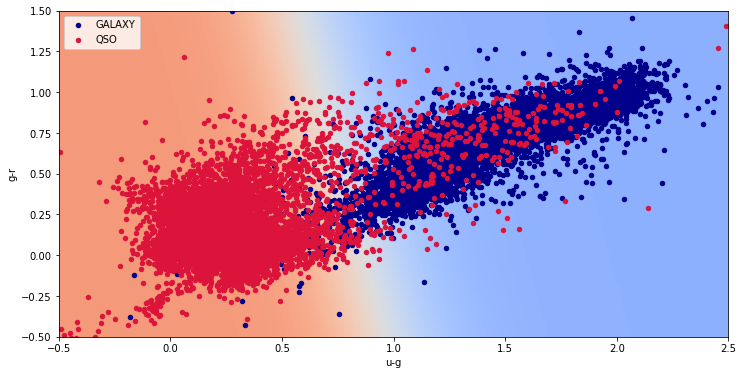

In [11]:
x0, x1 = np.meshgrid(np.arange(-1, 3, 0.01), np.arange(-1, 3, 0.01))
x = np.vstack([x0.flatten(), x1.flatten()]).T
t0 = network.predict(x).T[0].reshape(x0.shape)

fig, ax = plt.subplots(figsize=(12, 6))

ax.pcolormesh(x0, x1, t0, cmap='coolwarm', vmin=-0.5, vmax=1.5)
gal.plot.scatter(x='u-g', y='g-r', ax=ax, c='darkblue', label='GALAXY')
qso.plot.scatter(x='u-g', y='g-r', ax=ax, c='crimson', label='QSO')
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-0.5, 1.5)

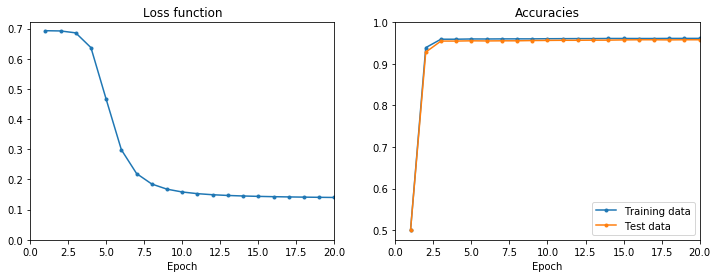

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
ax.plot(epochs, train_losses, '.-')
ax.set_title('Loss function')
ax.set_xlabel('Epoch')
ax.set_xlim(0, N_epoch)
ax.set_ylim(0, None)

ax = axes[1]
ax.plot(epochs, train_accs, '.-', label='Training data')
ax.plot(epochs, test_accs, '.-', label='Test data')
ax.set_title('Accuracies')
ax.set_xlabel('Epoch')
ax.set_xlim(0, N_epoch)
ax.set_ylim(None, 1)
ax.legend()

## One-layer network

- 1層ニューラルネットワークを作成し、実際に決定境界を図示してみる

In [13]:
class OneLayerNet:
    def __init__(self, input_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, output_size)
        self.params['b1'] = np.zeros(output_size)

    def predict(self, x):
        W1 = self.params['W1']
        b1 = self.params['b1']
    
        a1 = np.dot(x, W1) + b1
        y = softmax(a1)
        return y
    
    def loss(self, x, t):
        y = self.predict(x)
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        return np.sum(y==t) / float(x.shape[0])
        
    def gradient(self, x, t):
        W1 = self.params['W1']
        b1 = self.params['b1']
        
        # forward
        a1 = np.dot(x, W1) + b1
        y = softmax(a1)
        
        # backward
        grads = {}        
        dy = (y-t) / x.shape[0]
        grads['W1'] = np.dot(x.T, dy)
        grads['b1'] = np.sum(dy, axis=0)
        
        return grads

In [14]:
np.random.seed(2019)
network = OneLayerNet(2, 2)

N_iter = 2000
N_epoch = 20

epochs = np.arange(1, N_epoch+1)
train_losses = []
train_accs = []
test_accs = []
params = []

for i in tqdm(range(N_iter)):
    grad = network.gradient(x_train, t_train)
    
    for key in network.params:
        network.params[key] -= 0.1 * grad[key]
    
    if not i%int(N_iter/N_epoch):
        train_losses.append(network.loss(x_train, t_train))    
        train_accs.append(network.accuracy(x_train, t_train))
        test_accs.append(network.accuracy(x_test, t_test))
        params.append(deepcopy(network.params))

100%|██████████| 2000/2000 [00:01<00:00, 1091.37it/s]


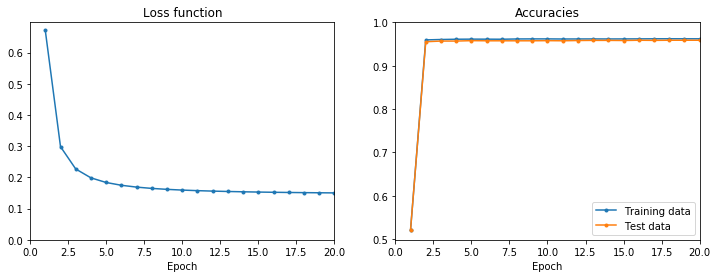

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
ax.plot(epochs, train_losses, '.-')
ax.set_title('Loss function')
ax.set_xlabel('Epoch')
ax.set_xlim(0, N_epoch)
ax.set_ylim(0, None)

ax = axes[1]
ax.plot(epochs, train_accs, '.-', label='Training data')
ax.plot(epochs, test_accs, '.-', label='Test data')
ax.set_title('Accuracies')
ax.set_xlabel('Epoch')
ax.set_xlim(0, N_epoch)
ax.set_ylim(None, 1)
ax.legend()

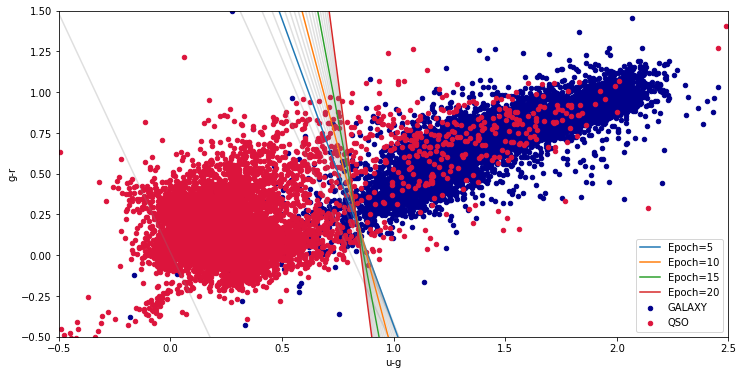

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))
gal.plot.scatter(x='u-g', y='g-r', ax=ax, c='darkblue', label='GALAXY')
qso.plot.scatter(x='u-g', y='g-r', ax=ax, c='crimson', label='QSO')
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-0.5, 1.5)

for i, epoch in enumerate(epochs):
    # see equation 4.10 in PRML
    W1 = params[i]['W1']
    b1 = params[i]['b1']
    dW1 = W1[:,0] - W1[:,1]
    db1 = b1[0] - b1[1]
    x0 = np.arange(-5, 5)
    x1 = -(dW1[0]*x0+db1)/dW1[1]
    
    if epoch%5:
        ax.plot(x0, x1, c='gray', alpha=0.25)
    else:
        ax.plot(x0, x1, label=f'Epoch={epoch}')

ax.legend()